<a href="https://colab.research.google.com/github/agawronski/word-embeddings/blob/main/20211114_1_group_together_similar_requests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np

In [2]:
articles_all = pd.read_csv('https://word-emeddings.s3.us-west-2.amazonaws.com/20211024_main_article_dataframe.csv')
articles_english = pd.read_csv('https://word-emeddings.s3.us-west-2.amazonaws.com/20211107_main_article_dataframe_small.csv')

In [3]:
# https://github.com/agawronski/word-embeddings/blob/main/get_embeddings/get_embeddings_jstor.py
# uses the 30 most frequent words of each document, and weighted average embedding with SentenceTransformer("all-mpnet-base-v2")
dataW = pd.read_csv('https://word-emeddings.s3.us-west-2.amazonaws.com/20211031_weighted_embeddings_saved_FULL.csv')

In [4]:
# https://github.com/agawronski/word-embeddings/blob/main/get_embeddings/get_embeddings_wiki_V2.py
# uses the full document and SentenceTransformer("all-mpnet-base-v2")
dataF = pd.read_csv('https://word-emeddings.s3.us-west-2.amazonaws.com/20211112_JSTOR_2_full_text_embeddings_saved_COMPLETED.csv')

In [5]:
# remove the very last article from "articles_all" because it is not part of the orginal dataset
articles_all = articles_all.loc[:articles_all.shape[0]-2,:]

In [6]:
articles_all.shape, dataW.shape

((1500, 34), (1500, 768))

In [7]:
articles_english.shape, dataF.shape

((1401, 3), (1401, 768))

In [8]:
# FIRST LETS USE THE WEIGHTED EMBEDDINGS 
# 2 different # of clusters:
# 20, roughly based on elbow method
# (n/10)

In [9]:
X = dataW

# use the elbow method to determine the number of clusters
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30)
 
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

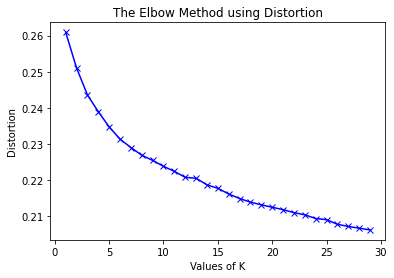

In [10]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

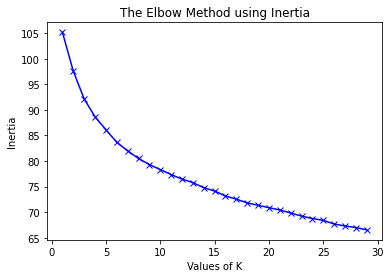

In [11]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [12]:
# # No clear elbow, let's use 20
# kmeansW = KMeans(n_clusters=20, random_state=42).fit(dataW)
# kmeansW.cluster_centers_
# # label the articles
# articles_all['clusters'] = kmeansW.labels_
# articles_all.clusters.value_counts()

In [13]:
# What does it look like if we randomly sample 5 from each cluster?
# They don't seem to be very relevant to each other at a glance.

# for c in articles_all.clusters.unique():
#   print('-'*100)
#   print(c)
#   subset = articles_all.loc[articles_all.clusters == c,:].sample(5, random_state=42)
#   for index, row in subset.iterrows():
#     print('cluster: ' + str(c) + ', article index #: ' + str(index))
#     print(row['fullText'][0:300])

In [14]:
kmeansW = KMeans(n_clusters=150, random_state=42).fit(dataW)
articles_all['clusters'] = kmeansW.labels_

In [16]:
for c in articles_all.clusters.unique()[0:15]:
  print('-'*100)
  print(c)
  subset = articles_all.loc[articles_all.clusters == c,:].sample(5, random_state=42)
  for index, row in subset.iterrows():
    print('cluster: ' + str(c) + ', article index #: ' + str(index))
    print(row['fullText'][0:1000])

----------------------------------------------------------------------------------------------------
47
cluster: 47, article index #: 311
['Group A rotaviruses (GARs) are the most common etiological agent of severe diarrhea in infants and young children worldwide, as well as being a common cause of acute enteritis in young farm animals [1] . They are members of the Rotavirus genus, within the Reoviridae family, and their genome consists of 11 segments of double-stranded RNA (dsRNA) encased in a triple-layered capsid. These segments encode six structural (VP1-VP4, VP6, and VP7) and five or six non-structural proteins. Amongst these, the outer capsid proteins VP7 and VP4, which independently elicit the production of neutralization antibodies, define the G and P serotypes, and form the basis of a binomial nomenclature [1] . In recent years, the serotype classification system has been almost completely replaced by a genotyping classification system based on sequence differences of the resp

In [17]:
kmeansW = KMeans(n_clusters=20, random_state=42).fit(dataW)
articles_all['clusters'] = kmeansW.labels_

In [18]:
distances = kmeansW.transform(dataW)

In [19]:
distances.shape

(1500, 20)

In [20]:
keep_ind = []
for c in range(0,20):
  one_cluster_dist = distances[:,c]
  one_cluster = np.argsort(one_cluster_dist)[0:5].tolist()
  keep_ind = keep_ind + one_cluster

In [21]:
subset = articles_all.loc[keep_ind,:].copy()

In [22]:
for c in subset.clusters.unique():
  print('-'*100)
  print(c)
  subset_small = subset.loc[subset.clusters == c,:]
  for index, row in subset_small.iterrows():
    print('cluster: ' + str(c) + ', article index #: ' + str(index))
    print(row['fullText'][0:1000])

----------------------------------------------------------------------------------------------------
0
cluster: 0, article index #: 635
['Avian infectious bronchitis (IB) is one of the most serious diseases of chickens. It is of economic importance in the poultry industry worldwide and is associated with respiratory disease, reduction in weight gain, poor egg production and quality, and decreased feed conversion efficiency. Its etiologic agent is the avian infectious bronchitis coronavirus (IBV), which is a Gamma coronavirus of the coronavirus genus and replicates primarily in the upper respiratory tract, kidney, and oviduct of chickens [1] [2] [3] .', 'Knowledge of the interactions between virus and host is critical in order to understand the pathogenesis of viral infection. On the one hand, the virus usurps the biological processes of the host to evade the innate immune response of the host; on the other hand, the host mounts a variety of defensive responses against the viral infecti

In [23]:
# SECOND USING THE EMBEDINGS BASED ON THE FULL TEXT
# same as before, 2 different # of clusters:
# 20, roughly based on elbow method
# (n/10)

In [24]:
X = dataF

# use the elbow method to determine the number of clusters
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30)
 
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

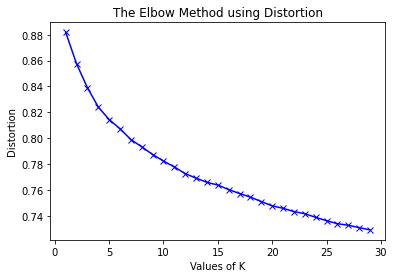

In [25]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

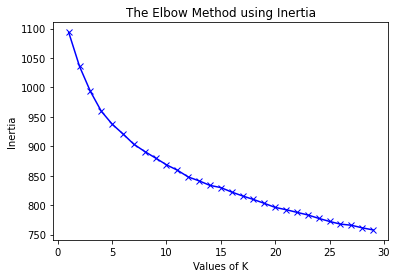

In [26]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [28]:
# # No clear elbow, let's use 20
# kmeansF = KMeans(n_clusters=20, random_state=42).fit(dataF)
# # label the articles
# articles_english['clusters'] = kmeansF.labels_
# articles_english.clusters.value_counts()

In [29]:
# What does it look like if we randomly sample 5 from each cluster?
# They don't seem to be very relevant to each other at a glance.

# for c in articles_english.clusters.unique():
#   print('-'*100)
#   print(c)
#   subset = articles_english.loc[articles_english.clusters == c,:].sample(5, random_state=42)
#   for index, row in subset.iterrows():
#     print('cluster: ' + str(c) + ', article index #: ' + str(index))
#     print(row['fullText'][0:1000])

In [30]:
kmeansF = KMeans(n_clusters=150, random_state=42).fit(dataF)
articles_english['clusters'] = kmeansF.labels_

In [31]:
for c in articles_english.clusters.unique()[0:15]:
  print('-'*100)
  print(c)
  subset = articles_english.loc[articles_english.clusters == c,:].sample(5, random_state=42)
  for index, row in subset.iterrows():
    print('cluster: ' + str(c) + ', article index #: ' + str(index))
    print(row['fullText'][0:10000])

----------------------------------------------------------------------------------------------------
124
cluster: 124, article index #: 1088
['6Evaluating Contrasting Approaches to Marine Ecotourism: ‘Dive Tourism’ and ‘Research Tourism’ in the Wakatobi Marine National Park, Indonesia Julian Clifton Introduction The establishment of marine protected areas (MPAs) in developing countries is perceived as solving problems of over-exploitation of ma- rine resources whilst also offering opportunities to promote alterna- tive sources of income for local communities through tourism- related activities (Boersma and Parrish 1999; Gubbay 1995). These activities, commonly referred to as nature-based tourism or eco- tourism, constitute one of the fastest growing sectors of the travel market (World Tourism Organisation 2002). Increasing consumer choice and spending ability in developed countries has led to an ex- pansion of destinations catering to tourists demanding increasingly remote and unspoile

In [32]:
kmeansF = KMeans(n_clusters=20, random_state=42).fit(dataF)
articles_english['clusters'] = kmeansF.labels_

In [33]:
distances = kmeansF.transform(dataF)

In [34]:
keep_ind = []
for c in range(0,20):
  one_cluster_dist = distances[:,c]
  one_cluster = np.argsort(one_cluster_dist)[0:5].tolist()
  keep_ind = keep_ind + one_cluster

In [35]:
subset = articles_english.loc[keep_ind,:].copy()

In [37]:
for c in subset.clusters.unique():
  print('-'*100)
  print(c)
  subset_small = subset.loc[subset.clusters == c,:]
  for index, row in subset_small.iterrows():
    print('cluster: ' + str(c) + ', article index #: ' + str(index))
    print(row['fullText'][0:10000])

----------------------------------------------------------------------------------------------------
0
cluster: 0, article index #: 975
['2. Governance Framework of Europe’s Pharmaceutical Sector Europe’s pharmaceutical sector is a highly regulated one. On the one hand, undertakings have to adhere to a healthcare policy framework mainly in- fluenced by patient safety and fiscal concerns. They however also benefit from opportunities to legally protect their products from product imitation. On the other hand, the behavior of pharmaceutical companies is governed by competition law. Although competition law doctrines are generally ap- plicable to all industry sectors, they enjoy certain special considerations when applied in the context of the drug industry’s characteristics. This chapter discusses important conflicts and opportunities of this governance framework relevant to analyze future implications on generic defense strategies. 2.1. Policy Objectives and Legal Protection 2.1.1. Confl